# MetroloPy

tools for dealing with physical quantities:  uncertainty propagation and unit conversion

---

## Table of Contents

* [getting started](#getting-started)
* [tutorial](#tutorial)
    * [expressing physical quantities](#expressing-physical-quantities)
    * [propagating uncertainty](#propagating-uncertainty)
    * [Monte-Carlo uncertainty propagation](#Monte-Carlo-uncertainty-propagation)
    * [expanded uncertainty](#expanded-uncertainty)
    * [an uncertainty budget](#an-uncertainty-budget)
    * [units and mathematical operations](#units-and-mathematical-operations)
    * [built-in and user defined units](#built-in-and-user-defined-units)
    * [physical constants](#physical-constants)
    * [curve fitting](#curve-fitting)
    * [applying numerical functions to gummys](#applying-numerical-functions-to-gummys)
    * [creating correlated gummys](#creating-correlated-gummys)
    * [complex numbers with uncertainty](#complex-numbers-with-uncertainty)
    * [formatting](#formatting)

## getting started

MetroloPy is a pure python package and requires Python 3.6 or later and the [SciPy stack](https://www.scipy.org/) (NumPy, SciPy and Pandas).  It looks best in a [Jupyter Notebook](https://jupyter.org/) like the one used to create this tutorial.

Install MetroloPy with pip:

```
$ pip install metrolopy
```

or with conda from conda-forge:

```
$ conda install -c conda-forge metrolopy
```

See the [MetroloPy home page](http://nrc-cnrc.github.io/MetroloPy/) for the full documentation.

---


## tutorial


### expressing physical quantities
A gummy object represents a physical quantity with an uncertainty and (or) a unit:

In [1]:
import metrolopy as uc

In [2]:
distance = uc.gummy(342.195,u=0.023,unit='m')
time = uc.gummy(1.00235,u=0.00044,unit='s')

distance/time

341.39(15) m/s

The uncertainty in the velocity is automatically calculated using first order uncertainty propagation.  By default, 
concise notation is used when a gummy is printed, where the numbers in parentheses represent the uncertainty in the 
last digits of the value. There are many other ways that the uncertainty can be notated, here is another example:

In [3]:
side_1 = uc.gummy(1.23456,u=0.00234,unit='cm',utype='B')
side_1

1.2346(23) cm

In [4]:
side_1.style='+-'
side_1

(1.2346 ± 0.0023) cm

You can set the default style for gummys by setting `gummy.style` at the class level (e.g. `uc.gummy.style = '+-'`).

Notice that the displayed value is rounded to two significant figures in the uncertainty.  You can change number of significant
figures in the uncertainty by setting the `gummy.nsig` property (either at the instance or class level).

We can express the uncertainty in different units:

In [5]:
side_1.uunit = 'um' # the uunit property sets the units on the uncertainty
side_1

1.2346 cm ± 23 μm

or express the uncertainty as a relative uncertainty:

In [6]:
side_1.uunit = '%'
side_1

1.2346 cm ± 0.19%

In [7]:
measurements = [3.011,3.125,2.995,3.055,3.067,3.101]
side_2 = uc.mean(measurements,unit='mm',utype='A')
side_2

3.059(20) mm with 5 degrees of freedom

(By default, the number of degrees of freedom is printed when it is less than 10.  This can be turned off by setting 
`side_b.show_dof = False`.  Set it to `None` to get back the default behavior. The global settings default for many
properties of newly created gummy instances can be set by setting the class properties, e.g. `uc.gummy.style` and 
`uc.gummy.show_dof`).

Up to this point we have been dealing with standard uncertainties (sometimes referred to roughly as 1-sigma uncertaities).
But often uncertainties are expressed as expanded uncertainties.  For example, if we want the uncerainty interval at a
95% level of confidence we can set the `gummy.p` property to 0.95 then the value and expanded uncertainty, calculated 
using a Student's <i>t</i> distribution with 5 degrees of freedom is:

In [8]:
side_2.p = 0.95
side_2

3.059(53) mm with a 95% level of confidence and 5 degrees of freedom

The expanded uncertainty can be accessed with the `U` property:

In [9]:
side_2.U

0.05268125101927068

While the standard uncertianty is still available with the lower case `u` property:

In [10]:
side_2.u

0.02049390153191918

The `.u` property always gives the standard uncertainty in the same units as the value (`.x`).

The `.k` property gives the coverage factor, which is the ratio $ U/u $.  Note that we can also 
set the `.k` property and then get the level of confidence corresponding that $ k $ value by 
reading the `.p` property.

In [11]:
side_2.show_k = True
side_2

3.059(53) mm with k = 2.6, a 95% level of confidence and 5 degrees of freedom

Here are the gummy properties that we have used so far:

In [12]:
print('side_2.x = {:f} (read only, value in units side_2.unit)'.format(side_2.x))
print('side_2.u = {:f} (read only, standard uncertainy in units side_2.unit)'.format(side_2.u))
print('side_2.U = {:f} (read only, expanded uncertainty in units side_2.uunit)'.format(side_2.U))
print('side_2.dof = {:f} (read only)'.format(side_2.dof))
print('side_2.unit = {:s} (setting this will affect side_2.x and side_2.u)'.format(str(side_2.unit)))
print('side_2.p = {:f} (setting this will affect side_2.k)'.format(side_2.p))
print('side_2.k = {:f} (setting this will affect side_2.p)'.format(side_2.k))
print('side_2.uunit = {:s} (None means that the units for side_2.U are the same as for side_2.x)'.format(str(side_2.uunit)))
print('side_2.utype = {:s} (read only)'.format(side_2.utype))

side_2.x = 3.059000 (read only, value in units side_2.unit)
side_2.u = 0.020494 (read only, standard uncertainy in units side_2.unit)
side_2.U = 0.052681 (read only, expanded uncertainty in units side_2.uunit)
side_2.dof = 5.000000 (read only)
side_2.unit = mm (setting this will affect side_2.x and side_2.u)
side_2.p = 0.950000 (setting this will affect side_2.k)
side_2.k = 2.570582 (setting this will affect side_2.p)
side_2.uunit = None (None means that the units for side_2.U are the same as for side_2.x)
side_2.utype = A (read only)


Note that we can set the `.unit` property for an in-place unit conversion, but we can also use the `.convert` 
method to return a copy of the gummy (e.g. `side_2_copy = side_2.convert('m')`).

We can also create a gummy based on an expanded uncertainty and/or relative uncertainty by using k, p and uunit 
keywords in the initializer:

In [13]:
g = uc.gummy(3.4457995,u=1.24,dof=7,p=0.95,unit='kg',uunit='ppm')
g

3.445 799 5 kg ± 1.2 ppm with a 95% level of confidence and 7 degrees of freedom

The `.u` property gives the standard uncertainty in kg:

In [14]:
g.u # this is equal to g.x*g.U*1e-6/g.k

1.8069642046180892e-06

### propagating uncertainty

Many numpy functions will work with gummys:

In [15]:
import numpy as np

In [16]:
angle = np.arctan(side_2/side_1)
angle

0.2429(16) with 5.8 degrees of freedom

In [17]:
angle.convert('degree')

13.916(93)° with 5.8 degrees of freedom

Or another example:

The gummys keep track of any correlations between values for example
if we define:

In [18]:
area = side_1*side_2
area

0.3777(26) cm² with 5.8 degrees of freedom

then there is a correlation between the area and the angle:

In [19]:
area.correlation(angle)

0.851780140482482

which can also be expressed as a covariance:

In [20]:
area.covariance(angle)

3.6403257452426167e-06

In [21]:
uc.gummy.correlation_matrix([angle,area])

[[1, 0.851780140482482], [0.851780140482482, 1]]

In [22]:
uc.gummy.covariance_matrix([angle,area])

[[2.641868561782402e-06, 3.6403257452426167e-06],
 [3.6403257452426167e-06, 6.913759482755993e-06]]

MetroloPy takes into account these correlations when propagating uncertainties.

Up to now we have assumed that the uncertainties are best modeled with a Normal probability distribution, but we can define a gummy with, say, a uniform probability distribution:

In [23]:
force = uc.gummy(uc.UniformDist(center=0.934566,half_width=0.0096),unit='N',utype='B')
force

0.9346(55) N

And we can calculate:

In [24]:
pressure = force/area
pressure

2.475(23) N/cm²

In [25]:
pressure.unit = 'kPa'
pressure

24.75(23) kPa

### Monte-Carlo uncertainty propagation

Above, gummy just took the standard deviation of the force probability distribution and then forgot about the shape and propagated the uncertainties assuming everything was Gaussian.  However we can also do a Monte-Carlo simulation using the actual probability distributions:

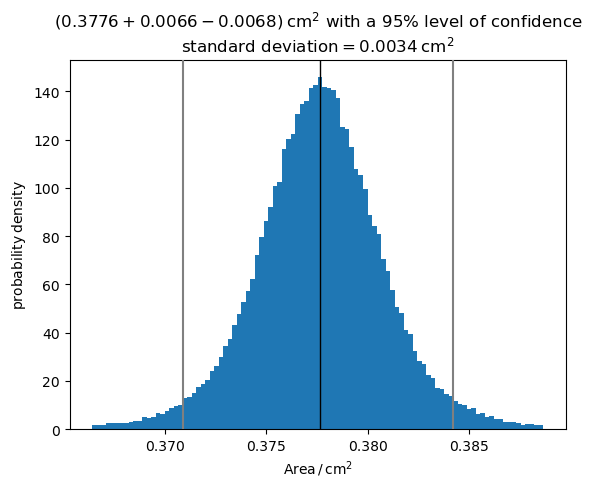

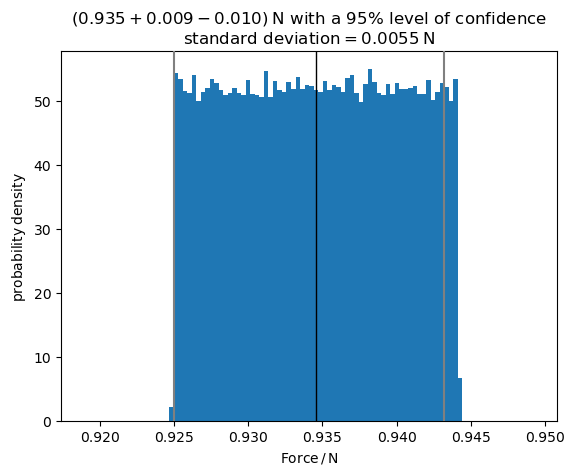

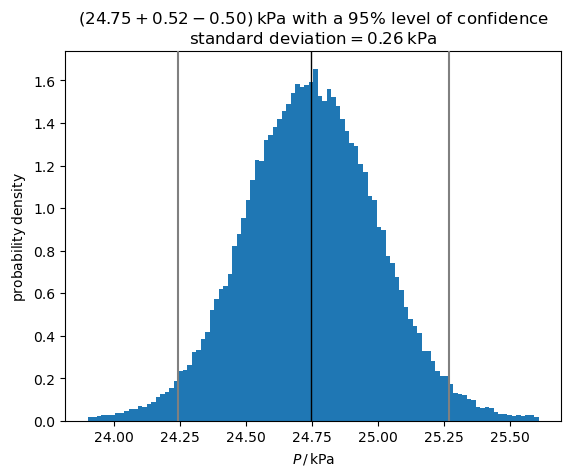

In [26]:
%matplotlib inline
uc.gummy.simulate([area,force,pressure])  # generate Monte-Carlo data, default is 1e6 samples for each gummy

area.name = 'Area'  #give the variables names for the plot
area.p = 0.95  # put the reference lines in the histograms at a 95% confidence interval
area.hist()  # create the histogram for a (we could have used a.hist(p=0.95) instead of a.p = 0.95 above)

force.name = 'Force'
force.p = 0.95
force.cimethod = 'symmetric'  # The default method for calculating confidence intervals is 
                          # cimethod = 'shortest', the shortest interval with the desired 
                          # confidence level.  But this doesn't work well with a uniform distribution.
force.hist()

pressure.name = 'Pressure'
pressure.p = 0.95
pressure.name = 'P'
pressure.hist()

The Monte-Carlo uncertainty above is pretty close (though not exactly the same as) the result from the
first order uncertainty propagation:

In [27]:
pressure

P = 24.75(48) kPa with a 95% level of confidence

### an uncertainty budget
Let's summarize the uncertainty budget in a table:

In [28]:
side_1.name = 'Side 1' # define names for the table listing
side_2.name = 'Side 2'
pressure.budget([side_1,side_2,force])

Component Unit  Value      u  DoF Type |dy/dx|    s
         Side 2   mm  3.059  0.020    5    A     8.1 0.54
          Force    N 0.9346 0.0055    ∞    B      26 0.42
         Side 1   cm 1.2346 0.0023    ∞    B      20 0.04
Combined type A  kPa          0.17  5.0    A         0.54
Combined type B  kPa          0.15    ∞    B         0.46
              P  kPa  24.75   0.23 17.4                  
  Uc at k = 2.1  kPa          0.48

By default the table is ordered with the most significant contributors to the uncertainty
at the top.

Maybe you prefer relative uncertainties in the table:

In [29]:
pressure.budget([side_1,side_2,force],uunit='%')

Component Unit  Value u / %  DoF Type |dy/dx|    s
         Side 2   mm  3.059  0.67    5    A     8.1 0.54
          Force    N 0.9346  0.59    ∞    B      26 0.42
         Side 1   cm 1.2346  0.19    ∞    B      20 0.04
Combined type A  kPa         0.67  5.0    A         0.54
Combined type B  kPa         0.62    ∞    B         0.46
              P  kPa  24.75  0.23 17.4                  
  Uc at k = 2.1  kPa          1.9

### units and mathematical operations

During mathematical operations, gummys will automatically convert units if necessary:

In [30]:
x = uc.gummy(1.2,unit='cm')
y = uc.gummy(2.1,unit='in')
x + y

6.534 cm

In [31]:
x*y

6.4008 cm²

Use the c flag to control the unit conversion.  Put the .c property on the unit that you want converted:

In [32]:
x.c + y

2.572 440 944 881 89 in

In [33]:
x.c*y

0.992 125 984 251 969 in²

Nonlinear units (e.g. the decibel) or units with a offset origin may affect the way gummys behave under mathematical operations:

In [34]:
t1 = uc.gummy(27,unit='degC')
t2 = uc.gummy(19,unit='degC')
difference = t1 - t2  # t1 + t2 will raise an exception
difference

8 °C

The difference looks like it has units degree Celsius, however gummy understands that it represents a temperature interval:

In [35]:
difference.unit.name

'degree Celsius interval'

In [36]:
difference.convert('K')

8 K

This is different from, say `t1` defined above:

In [37]:
t1.unit.name

'degree Celsius'

In [38]:
t1.convert('K')

300.15 K

### built-in and user defined units

A number of units are built into gummy.  Use the search_units function to search them:

In [39]:
uc.search_units('length',fmt='html')
# uc.search_units() with no argument displays all loaded units

angstrom, 1 Å = 1e-10 m, alias: Å
astronomical unit, 1 au = 1.495 978 707e+11 m, aliases: au, ua
bohr, 1 a0 = 5.291 772 105 41(80)e-11, aliases: a0, a(0)
cable, 1 cb = 120 ftm, alias: cb
chain, 1 ch = 4 rd, alias: ch
fathom, 1 ftm = 2 yd, alias: ftm
foot, 1 ft = 12 in, alias: ft
furlong, 1 fur = 10 ch, alias: fur
hand, 1 hand = 4 in
inch (1 prefix), 1 in = 0.0254 m, alias: in
league, 1 lea = 3 mi, alias: lea
light hour, 1 light-hour = 1 c h, alias: light-hour
light minute, 1 light-minute = 1 c min, alias: light-minute
light second, 1 light-second = 1 c s, alias: light-second
light year, 1 ly = 1 c a, alias: ly
link, 1 li = 0.66 ft, alias: li
metre (20 prefixes), symbol: m, aliases: m, meter
mile, 1 mi = 1760 yd, alias: mi
nautical mile, 1 M = 1852 m, aliases: M, NM, Nm, nmi
parsec (3 prefixes), 1 pc = 206 264.806 247 096 363 2(97) au, alias: pc
pica, 1 P/ = 1/6 in, alias: P/
Planck length, 1 l(P) = 1.616 255(18)e-35 m, alias: l(P)
point, 1 p = 1/12 P/, alias: p
rack unit, 1 U = 1.75 in
reduced Compton wavelength, 1 ƛ(C) = 1 ℏ/(m(e) c), aliases: lambda(C), ƛ(C)
rod, 1 rd = 25 ft, alias: rd
siriometer, 1 Sm = 1 000 000 au
survey foot, 1 ft = 1200/3937 m
survey mile, 1 mi = 8 fur, alias: statute mile
thousandth of an inch, 1 mil = 0.001 in, aliases: mil, thou, thousandth
yard, 1 yd = 3 ft, alias: yd

You can also create custom units.  Creating an instance of the Unit class automatically loads the unit definition into the unit library so it can be accessed by its string name.  The Unit class has two required parameters, the unit name and the unit symbol.  

In [40]:
uc.Unit('weird meter','wm',conversion=uc.Conversion('m',0.9144),add_symbol=True)

wm

The optional conversion defines a unit conversion, in this case 1 wm = 0.9144 m.  Because add_symbol was set to True when creating the unit, we can access the unit using its symbol 'wm' as well as by its name '[weird meter]' ( the brackets are required because there is a space in the name):

In [41]:
w = uc.gummy(1,unit='wm')
w

1 wm

In [42]:
w.convert('m')

0.9144 m

### physical constants

MetroloPy includes some built-in constants, for example:

In [43]:
uc.constant('G')

G = 6.674 30(15)e-11 m³/(kg s²)

In [44]:
uc.constant('G').description

'Newtonian constant of gravitation, CODATA 2022'

Correlations between constants are correctly handled.  For example the proton and electron masses are know to about 0.3 ppb, 
however the ratio of the masses has a smaller uncertainty.

In [45]:
me = uc.constant('m(e)')
me.uunit = 'ppb'
me

m(e) = 9.109 383 714 0e-31 kg ± 0.30 ppb

In [46]:
mp = uc.constant('m(p)')
mp.uunit = 'ppb'
mp

m(p) = 1.672 621 925 97e-27 kg ± 0.30 ppb

In [47]:
r = mp/me
r.uunit = 'ppb'
r

1 836.152 673 426 ± 0.017 ppb

Constants can be found with `search_constants` function:

In [48]:
uc.search_constants('electron')

classical electron radius r(e) = 2.817 940 320 4(13)e-15 m, alias: r(e)
Compton wavelength λ(C) = 2.426 310 235 35(73)e-12 m, aliases: lambda(C), λ(C)
electron g factor g(e-) = -2.002 319 304 360 92(36), alias: g(e-)
electron gyromagnetic ratio γ(e) = 1.760 859 627 82(53)e+11 1/(T s), aliases: gamma(e), γ(e)
electron magnetic moment μ(e) = -9.284 764 691 6(28)e-24 J/T, aliases: mu(e), μ(e)
electron magnetic moment anomaly a(e) = 0.001 159 652 180 46(18), alias: a(e)
electron mass m(e) = 9.109 383 714 0e-31 kg ± 0.30 ppb, alias: m(e)

The constants can be referenced by name or alias.  To list all constants, call the `search_constants` function with no arguments.

Users can also define constants to be added to the constant library:

In [49]:
uc.GummyConstant(1.75,unit='in',name='rack constant',symbol='rk',description='see also "rack unit"',add_symbol=True)
uc.constant('rk')

rk = 1.75 in

### curve fitting

The gummy package also includes several classes for fitting functions, for example:

In [50]:
y0 = uc.gummy(0.11,2.2,unit='m')
y1 = uc.gummy(2.12,1.2,unit='m')
y2 = uc.gummy(3.02,1.3,unit='m')
y3 = uc.gummy(5.55,2.3,unit='m')
y4 = uc.gummy(16.22,1.2,unit='m')

fit = uc.PolyFit([0,1,2,3,4],[y0,y1,y2,y3,y4],deg=2,xunit='s')
fit

y = p(1) + p(2)*x + p(3)*x**2

best fit parameters:
p(1) = 1.7(19) m
p(2) = -1.9(20) m/s
p(3) = 1.37(43) m/s²

We can plot the fit along with the standard uncertainty in the fit at any point:

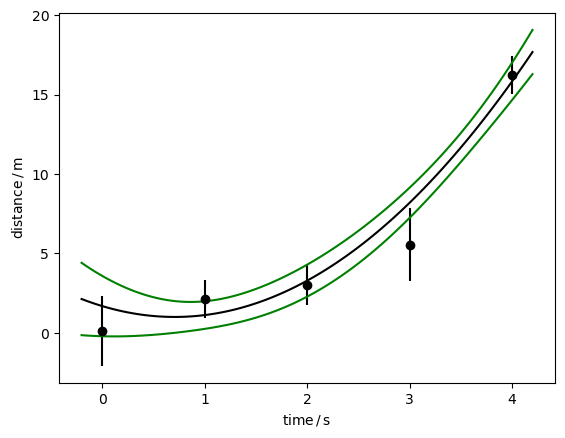

In [51]:
fit.plot(cik=1,xlabel='time',ylabel='distance')  
# cik is the coverage factor for the fit uncertainty band,
# alterately the cip parameter can be set to give a
# probability level for the band

There are several other fit classes:

In [52]:
x = np.linspace(0,10,100)
y = np.sin(x + 0.88) + 1.3 + np.random.normal(scale=0.23,size=100)

sinfit = uc.SinFit(x,y,xunit='t',yunit='m')
sinfit

y = p(1)*sin(p(2)*x + p(3)) + p(4)

best fit parameters:
p(1) = 1.004(34) m
p(2) = 1.003(13) 1/t
p(3) = 0.871(76)
p(4) = 1.329(25) m

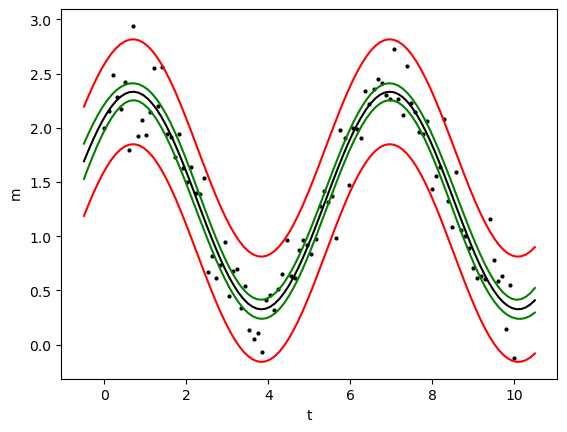

In [53]:
sinfit.plot(cip=0.95,clp=0.95)  
# cip is the level of confidence for the fit uncertainty band in green

# clp (or clk) sets control limits in red, the region where the data points
# arelikely to lie

The predicted value is a gummy (and is correlated with the fit parameter gummys):

In [54]:
sinfit.ypred(5.2)

1.134(49) m

User defined functions can be fit with the `Fit` class, either by passing the function 
to the constructor of `Fit` or by sub-classing `Fit`.

### applying numerical functions to gummys

A number of mathematical functions that can be used with gummys are included with the gummy package:

In [55]:
a = uc.gummy(1.233,0.022)
uc.sin(a)

0.9435(73)

Many NumPy functions can also be used with gummys:

In [56]:
import numpy as np
np.sin(a)

0.9435(73)

The `apply` static method can also be used to apply a arbitrary numerical function to a gummy or several gummys.  The apply method takes as its first parameter the function, which must take one or more float parameters and return a float or list or numpy.ndarray of floats.  The second parameter is another function which gives the derivative of the first function.  The remaining parameters are the gummy(s) or float(s) to which the function will be applied.  We also demonstrate here that gummy can be used with the mpmath package to work with extended precision floating point types:

In [57]:
# the mpmath package can be installed with pip or conda
from mpmath import sin, cos, mpf, mp

mp.dps = 50
# set mpmath to a precision of 50 digits

uc.gummy.max_digits = 50
# by default gummy doesn't display more than 20 digits;
# this option does not affect the working precision, only 
# the display

a = uc.gummy(mpf('1/3'),mpf('2.2e-45'))

uc.gummy.apply(sin,cos,a)

0.327 194 696 796 152 244 173 344 085 267 620 606 064 301 406 9(21)

The napply static method is similar to the apply method except that the derivatives are calculated numerically and do not need to be applied:

In [58]:
uc.gummy.napply(sin,a)

0.327 194 696 796 152 244 173 344 085 267 620 606 064 301 406 9(21)

In [59]:
#set the max digits back to its original value
uc.gummy.max_digits = 20

### creating correlated gummys

Use the create static method to generate a list of correlated gummys:

In [60]:
g = uc.gummy.create([1.1,2.2,3.3],u=[0.3,0.1,0.4],correlation_matrix=[[1,0,0.5],[0,1,0],[0.5,0,1]])
g

[1.10(30), 2.20(10), 3.30(40)]

In [61]:
g[0].covariance(g[2])

0.05999999999999998

The `covariance_matrix` key word can be used in the `create` method in place of `u` and `correlation_matrix`.

Note that mathematical operations between gummys will also create correlations between the input and output gummys.

### complex numbers with uncertainty

The `jummy` class can be used to represent complex numbers with uncertainties:

In [62]:
c = uc.jummy(real=1.334,imag=0.2345,cov=[[0.0127,0.0055],[0.0055,0.0334]])
c

1.33(11) + j0.23(18)

Polar coordinates can also be used:

In [63]:
c.style='polar'
c

1.35(12) exp(j0.17(13))

In [64]:
d = uc.jummy(r=2.445,phi=4.556,cov=[[0.022,0],[0,0.044]])
d

-0.38(51) - j2.42(17)

The `.real`, `.imag`, `.r` and `.phi` properties return gummy values:

In [65]:
e = c + d**2
e

-4.4(10) + j2.1(24)

In [66]:
e.real

-4.4(10)

In [67]:
e.imag

2.1(24)

In [68]:
e.r

4.82(80)

In [69]:
e.phi

2.70(52)

### formatting

By default in a Jupyter notebook, gummy output is rendered using HTML:

In [70]:
acceleration = fit.p[2]
acceleration

1.37(43) m/s²

But they can also be displayed using LaTeX:

In [71]:
acceleration.latex()

<IPython.core.display.Math object>

The latex() method is like a print command but rendering the output with LaTeX.  There is also a html() method.  Output can also be printed using only ASCII or unicode characters:

In [72]:
acceleration.ascii()

1.37(43) m/s**2


In [73]:
acceleration.unicode()

1.37(43) m/s²


Use the tolatex() or tohtml() methods to get a string with the LaTeX or HTML encoding for the gummy.

In [74]:
acceleration.tolatex()

'1.37(43)\\:\\mathrm{m}/\\mathrm{s}^{2}'

In [75]:
acceleration.tohtml()

'<span>1.37(43)&nbsp;m/s<sup>2</sup></span>'

It is also possible to change the default output to LaTeX:

In [76]:
uc.gummy.printer = 'latex'
acceleration

$ 1.37(43)\:\mathrm{m}/\mathrm{s}^{2} $

or unicode:

In [77]:
uc.gummy.printer = 'unicode'
acceleration

1.37(43) m/s²

or output using only ASCII characters:

In [78]:
uc.gummy.printer = 'ascii'
acceleration

1.37(43) m/s**2

or back to HTML:

In [79]:
uc.gummy.printer = 'html'
acceleration

1.37(43) m/s²

Uncertainty budgets and fits can also be rendered using LaTeX:

In [80]:
budget = pressure.budget([side_1,side_2,force],uunit='%')
budget.latex()

<IPython.core.display.Math object>

In [81]:
budget.tolatex()

'\\begin{array}{ c c c c c c c c }\n\\text{Component} & \\text{Unit} & \\text{Value} & u\\,/\\,\\mathrm{\\%} & \\nu_{eff} & \\text{Type} & \\left\\lvert\\frac{\\partial y}{\\partial x} \\right\\rvert & s \\\\\n\\hline\n\\text{Side 2} & \\mathrm{mm} & 3.059 & 0.67 & 5 & \\text{A} & 8.1 & 0.54 \\\\\n\\text{Force} & \\mathrm{N} & 0.9346 & 0.59 & \\infty & \\text{B} & 26 & 0.42 \\\\\n\\text{Side 1} & \\mathrm{cm} & 1.2346 & 0.19 & \\infty & \\text{B} & 20 & 0.04 \\\\\n\\hline\nu_{c} \\text{ type A} & \\mathrm{kPa} &  & 0.67 & 5.0 & \\text{A} &  & 0.54 \\\\\nu_{c} \\text{ type B} & \\mathrm{kPa} &  & 0.62 & \\infty & \\text{B} &  & 0.46 \\\\\n\\hline\nP & \\mathrm{kPa} & 24.75 & 0.23 & 17.4 & \\text{} &  &  \\\\\n\\hline\nU_c \\text{ at } k = 2.1 & \\mathrm{kPa} &  & 1.9 &  & \\text{} &  &  \\\\\n\\end{array}'

As can the ouput of the fit from the curve fitting section:

In [82]:
fit.latex()

<IPython.core.display.Math object>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
&copy; Copyright 2025, National Research Council Canada
</footer>